# Prerequisites

In [1]:
import sys

sys.path.append("..")

In [2]:
import argparse
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import display
from torchvision.models import resnet18, resnet50
from tqdm.notebook import tqdm

from dataset import (
    HWSet,
    transform_shared,
    normalize_hw,
    normalize_hw_mask,
    normalize_inv_hw,
    normalize_inv_hw_mask,
)
from util import eval_step, get_obj_score, get_performance, get_saliency

C:\Users\runes\.conda\envs\context\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [3]:
data_dir = "../data"
class_legend = ("Siberian Husky", "Grey Wolf")
model_types = {"r18": "ResNet 18", "r50": "Resnet 50"}

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")


def get_model(model_type, device="cpu", seed=191510):
    torch.manual_seed(seed)
    if model_type == "r18":
        model = resnet18(weights=None)
    elif model_type == "r50":
        model = resnet50(weights=None)
    model.fc = torch.nn.Linear(
        in_features=model.fc.in_features, out_features=len(class_legend), bias=True
    )
    model.to(device)
    return model

Using device: cuda


# Load models

In [4]:
model_type = "r18"
split = "val"
# run_dir = "../models/hw-checkpoints/run-20240314-213449"
# run_dir = "../models/hw-checkpoints/run-20240317-161421"
run_dir = "../models/hw-checkpoints/run-20240318-153036"

names = [p for p in os.listdir(run_dir) if os.path.isdir(f"{run_dir}/{p}")]
models = {name: get_model(model_type, device=device) for name in names}

cpts = {}
for name in names:
    m_cpts = os.listdir(f"{run_dir}/{name}")
    max_epoch = -1
    for cpt in m_cpts:
        if "best" in cpt:
            cpts[name] = cpt
            break
        epoch = int(cpt.split("_")[1].split(".")[0][1:])
        if epoch > max_epoch:
            cpts[name] = cpt
            max_epoch = epoch
print(cpts)

for name in models:
    checkpoint = torch.load(f"{run_dir}/{name}/{cpts[name]}")
    models[name].load_state_dict(checkpoint["model_state_dict"])
    models[name].eval()

{'a': 'r18_e93_best.cpt', 'b': 'r18_e216_best.cpt', 'c': 'r18_e136_best.cpt'}


# Predictions on images of humans

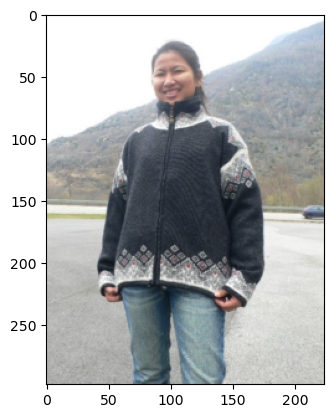

In [5]:
dset = HWSet(data_dir, 'val', transform=transform_shared)

human_imgs_dir = f'{data_dir}/val_humans'
imgs = [f"{human_imgs_dir}/{img_file}" for img_file in os.listdir(human_imgs_dir)]
imgs = list(filter(os.path.isfile, imgs))

dset.imgs = imgs
dset.labels = np.array(len(imgs) * [-1])

im, _ = dset[0]
plt.imshow(np.moveaxis(im.numpy(), 0, -1));

In [6]:
preds = {
    k: list() for k in models
}

for item in tqdm(range(len(dset))):
    im, _ = dset[item]
    imgs = im.unsqueeze(0)
    
    inputs = {"a": normalize_hw(imgs), "b": normalize_hw_mask(imgs), "c": normalize_hw_mask(imgs)}
    for k, imgs_in in inputs.items():
        out = models[k](imgs_in.to(device))
        _, indices = torch.max(out, 1)
        preds[k].append(indices.detach().item())

  0%|          | 0/180 [00:00<?, ?it/s]

In [7]:
counts = {k: {t: 0 for t in range(len(class_legend))} for k in models}
for k, preds_model in preds.items():
    for pred in preds_model:
        counts[k][pred] += 1

counts

{'a': {0: 146, 1: 34}, 'b': {0: 110, 1: 70}, 'c': {0: 100, 1: 80}}

In [8]:
# plt.bar([k.upper() for k in counts.keys()], [v[0] / len(dset) for v in counts.values()], width=0.5);

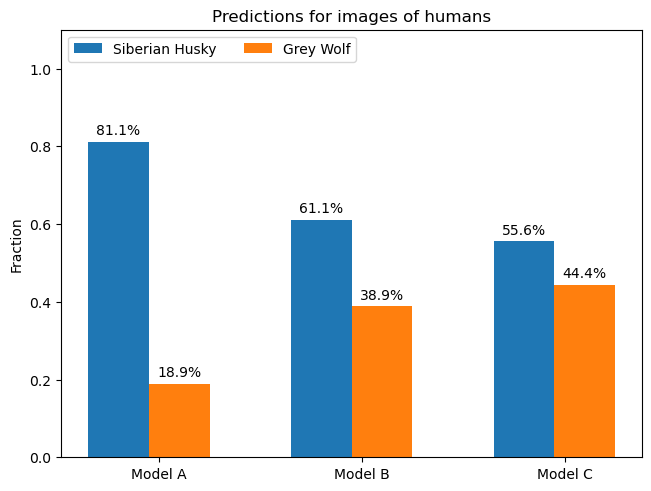

In [36]:
# species = ("Adelie", "Chinstrap", "Gentoo")
# penguin_means = {
#     'Bill Depth': (18.35, 18.43, 14.98),
#     'Bill Length': (38.79, 48.83, 47.50),
#     'Flipper Length': (189.95, 195.82, 217.19),
# }

x = np.arange(len(models))  # the label locations
width = 0.30  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for c in range(len(class_legend)):
    offset = width * multiplier
    rects = ax.bar(x + offset + .10, [v[c] / len(dset) for v in counts.values()], width, label=class_legend[c])
    ax.bar_label(rects, fmt='{:.1%}', padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Fraction')
ax.set_title('Predictions for images of humans')
ax.set_xticks(x + width, [f"Model {k.upper()}" for k in models])
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.10)
# ax.axhline(len(dset), ls='--', c='red')

plt.show()